# Classifying Simpsons characters in images


## Dataset:

Many thanks to [jbencina](https://github.com/jbencina) for making this dataset available. The dataset is available on github [here](https://github.com/jbencina/simpsons-image-training-dataset): 

> Collection of 30,693 frames from 65 Simspsons episodes from seasons 3, 4, and 5. Each image is **160x120** pixels.
> 
> One collection (faces-clean-color) contains isolated frames of Homer (n=1,041), Marge (n=444), Lisa (n=358), and Bart (n=645) totalling (n=2,488). These files are labled as {instance_number}_{character_name}.jpg. 
> 
> The second collection (unsorted-color) contains 28,205 unsorted frames which can contain backgrounds, characters, text, etc. The two sets are mutually exclusive. This has been broken up into several archives for upload.

This basically gives us 2488 images to train a Simpsons-classifier-model on. Here we go!


1071 Example of an image where it thinks it's marge but it's actually homer. Main reason is probably the blue background. This causes it to think it's marges hair.

In [1]:
from scipy import misc
from scipy.ndimage import find_objects,label

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

from os import listdir
from os.path import isfile, join

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

### Test data split

I took out 120 images (30 of each character) from the labeled dataset and moved it to a test folder. I'll use this to test my model and see how well it classifies. 

In [2]:
image_path = "c:/projects/simpsons/faces"
image_path_test = "c:/projects/simpsons/faces_test"

image_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]
image_list_test = [f for f in listdir(image_path_test) if isfile(join(image_path_test, f))]

I'm using regex to extract the target values from the file names. 

In [3]:
regex_pat = '_([a-z]+).jpg'

target_array = np.array([re.findall(regex_pat,f)[0] for f in image_list])
target_array_test = np.array([re.findall(regex_pat,f)[0] for f in image_list_test])

In [4]:
name_list, name_list_counts = np.unique(target_array, return_counts=True)

### Equal spread on input data

The initial input was skewed towards Homer and Bart. I evened out the training data.

In [5]:
at_most = min(name_list_counts)

image_list_by_character = []
image_list_filtered = []

for i in name_list:
    image_list_by_character.append([x for x in image_list if x.find(i) > 0])

for i in image_list_by_character:
    image_list_filtered = image_list_filtered+i[0:at_most]
    
image_list_filtered = np.array(image_list_filtered)

Time to read in the actual images from the new `image_list` 

In [6]:
image_array = [misc.imread('faces/' + f).astype(np.uint8) for f in image_list_filtered]
image_array = np.array(image_array)

image_array_test = [misc.imread('faces_test/' + f).astype(np.uint8) for f in image_list_test]
image_array_test = np.array(image_array_test)

Need to recalculate the target array as it needs to have less values now.

In [7]:
target_array = np.array([re.findall(regex_pat,f)[0] for f in image_list_filtered])
target_array_test = np.array([re.findall(regex_pat,f)[0] for f in image_list_test])

Reshaping the image array to the shape [*num_images* , *num_cols*]. In this case the number of images is 1312 in our training set. The number of cols is 57600. 

The images are 120 by 160 pixels. Each image therefore has 19200 pixels. Each pixel is represented by 3 RGB values so each pixel has 3 values by itself. So in total, each image has 57600 columns of data. 

In [8]:
image_array = image_array.reshape((-1, 1, 57600))
image_array_test = image_array_test.reshape((-1, 1, 57600))

In [9]:
train_x = image_array[:,0]
train_y = target_array

In [10]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_x, train_y)
pred = rf.predict(image_array_test[:,0])
print(metrics.classification_report(target_array_test, pred))

             precision    recall  f1-score   support

       bart       0.71      0.80      0.75        30
      homer       0.83      0.80      0.81        30
       lisa       0.79      0.73      0.76        30
      marge       0.93      0.90      0.92        30

avg / total       0.81      0.81      0.81       120



### Intermediate result

By applying standard RandomForest I end up with a f-score of **81%**. 

### Next improvement

Use GridSearchCV to find the best configuration for the RandomForest classifier. I was hardcoding the `n_estimators` on 100 but I was wondering if this shouldn't be optimized automatically. After googling I found GridSearch. I can use this to optimize the settings for my RandomForest. Let's do that!

In [13]:
from sklearn.grid_search import GridSearchCV

param_grid = { 
    'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120]
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_x, train_y)
print(CV_rfc.best_params_)

{'n_estimators': 80}


In [13]:
rf = RandomForestClassifier(n_estimators=80)
rf.fit(train_x, train_y)
pred = rf.predict(image_array_test[:,0])
print(metrics.classification_report(target_array_test, pred))

             precision    recall  f1-score   support

       bart       0.84      0.87      0.85        30
      homer       0.79      0.87      0.83        30
       lisa       0.89      0.80      0.84        30
      marge       0.93      0.90      0.92        30

avg / total       0.86      0.86      0.86       120



### Intermediate result

After changing the number of estimators from 100 to 80, as suggested by the grid search, the accuracy remained almost the same, maybe slightly better.

### Next improvement

Currently it's using the entire image to classify. However a large portion of the images are useless background information. Especially the pixels on the left and right edge contain background pixels. Let's try snipping off the edges. I'll reduce the image by 20 pixels from each side.

In [14]:
def trim_image(img):
    return img[20:-20]

In [15]:
image_array = [misc.imread('faces/' + f).astype(np.uint8) for f in image_list_filtered]
image_array = np.array(image_array)

image_array_test = [misc.imread('faces_test/' + f).astype(np.uint8) for f in image_list_test]
image_array_test = np.array(image_array_test)

image_array_new = np.empty((1312,120,120,3), int)

for i,j in enumerate(image_array):
    for l,o in enumerate(j):
        image_array_new[i][l] = trim_image(o)

In [16]:
image_array_test_new = np.empty((len(image_array_test),120,120,3), int)
for i,j in enumerate(image_array_test):
    for l,o in enumerate(j):
        image_array_test_new[i][l] = trim_image(o)

In [17]:
image_array_new = image_array_new.reshape((-1, 1, 120*120*3))
image_array_test_new = image_array_test_new.reshape((-1, 1, 120*120*3))

In [20]:
train_x = image_array_new[:,0]
train_y = target_array

rf = RandomForestClassifier(n_estimators=80)
rf.fit(train_x, train_y)
pred = rf.predict(image_array_test_new[:,0])
print(metrics.classification_report(target_array_test, pred))

             precision    recall  f1-score   support

       bart       0.81      0.83      0.82        30
      homer       0.78      0.83      0.81        30
       lisa       0.89      0.80      0.84        30
      marge       0.93      0.93      0.93        30

avg / total       0.85      0.85      0.85       120



### Result

The f-score was slightly better on average but it did not affect the score as much as I expected.

### Lesson learned #1

One of my initial models had a strong bias towards predicting Bart and Homer while at the same time Lisa was not getting predicted as often as she should. Turns out the number of input images was skewed. There were many more Homers and Barts then Lisa's. 

I then tried 'limiting' the input images to the minimum number. The character with the least amount of labeled images in the dataset is Lisa who has 338 of them. This means that I might have 1041 images of homer but I'm only using 338. The model is being trained on 338 images of Lisa, 338 images of Bart, 338 images of Marge and 338 images of Homer. 

I'm not sure if elimating potential training material is best practice but in this case this did cause the model to improve significantly.

### Lesson learned #2

Use a package like GridSearch to optimize the settings (for example n_estimators) you provide to the classifier algorithm. 


## Questions

* Is it good to reduce your input to prevent introducing a skew in data?
* Grid search suggested changing the `n_estimators` to 80. The results were worse of. is this a worthwhile change?
* The results of a RandomForest after different each time. Is this normal?

## Final considerations

Another thing I could try to implement is some sort of **face detection** package. I could use this to pinpoint the pixels. This should would probably improve the model even more then simply trimming off pixels from the edges.

I tried using OpenCV but I was not able to get the install working (Windows). I'm my next face-recognition project I will use OpenCV2.

I could also manually classify some more images so I have more data to train on. I might try that on a later date.

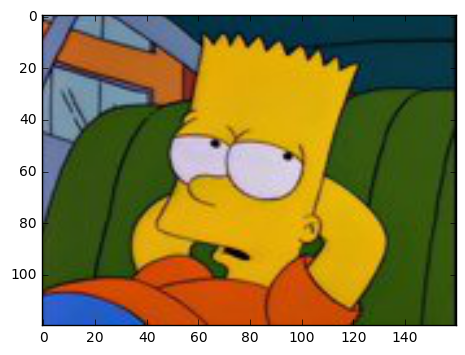

## Randomness

These are the 'mean' images of the characters, based on 20 images.

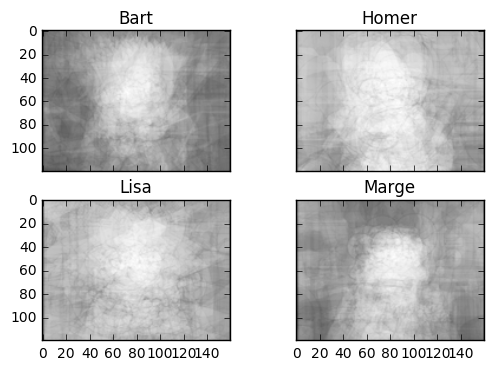

In [55]:
bart_images = image_list_by_character[0][0:20]
homer_images = image_list_by_character[1][0:20]
lisa_images = image_list_by_character[2][0:20]
marge_images = image_list_by_character[3][0:20]

bart_array = np.array([misc.imread('faces/' + f, flatten=True).astype(np.uint8) for f in bart_images])
homer_array = np.array([misc.imread('faces/' + f, flatten=True).astype(np.uint8) for f in homer_images])
lisa_array = np.array([misc.imread('faces/' + f, flatten=True).astype(np.uint8) for f in lisa_images])
marge_array = np.array([misc.imread('faces/' + f, flatten=True).astype(np.uint8) for f in marge_images])

bart_avg = np.average(bart_array, axis=0)
homer_avg = np.average(homer_array, axis=0)
lisa_avg = np.average(lisa_array, axis=0)
marge_avg = np.average(marge_array, axis=0)

f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(bart_avg, cmap='Greys_r')
axarr[0, 0].set_title('Bart')
axarr[0, 1].imshow(homer_avg, cmap='Greys_r')
axarr[0, 1].set_title('Homer')
axarr[1, 0].imshow(lisa_avg, cmap='Greys_r')
axarr[1, 0].set_title('Lisa')
axarr[1, 1].imshow(marge_avg, cmap='Greys_r')
axarr[1, 1].set_title('Marge')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plt.show()

This is me while fitting the models.

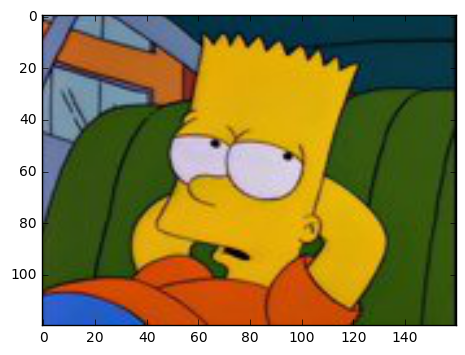

In [57]:
plt.imshow(misc.imread('faces/10_bart.jpg'))
plt.show()

The model was struggling with this image. It misclassifying it as Marge. Obviously due to the blue background which made it think it was showing marge's hair

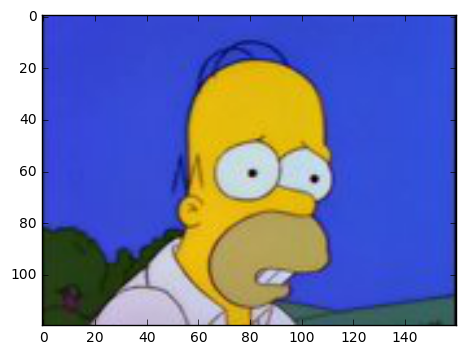

In [61]:
plt.imshow(misc.imread('faces_test/1071_homer.jpg'))
plt.show()